# Teste de Classificadores com ajuste de peso e modelos de arvore com up/downsampling 

O objetivo é testar os modelos XGBoost e adaBoost sem sampling e a floresta aleatoria e arvore de decisão com sampling, analisar qual deles tem a melhor metrica de recall para o banco de dados com todas as 4 tabelas e qual tem o melhor ponto de cotovelo na curva recall-precision.

## Preparar os dados e criar classe de processamento 

### Importando bibliotecas e dados

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [2]:
%load_ext autoreload
%autoreload 2

import os, sys

#Importing path to main folder, subtitute with your own path
module_path = os.path.abspath(os.path.join('/Users/mhctds/visage-V1.1')) # or the path to your source code
sys.path.insert(0, module_path)


In [3]:
from src.data.DataProcessing import DataProcessing
from src.models.ModelProcessing import ModelProcessing
from src.metrics.MetricsProcessing import MetricsProcessing
from src.models.BertProcessing import BertProcessing

/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_denuncia_crime=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/base_apps_denuncia_crime.csv')
df_base_rocinha=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/base_rocinha_df.csv')
df_protestos_2013=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/protestos_2013_df.csv')
df_protestos_PMES=pd.read_csv('/Users/mhctds/Cidade_Social/base de dados/protestos_PMES.csv')

### Criar classe de processamento

### Unir dataframes e separar em features e target

In [5]:
df_vector=[df_base_rocinha,df_denuncia_crime,df_protestos_2013,df_protestos_PMES]
DataProcess=DataProcessing()
df_final=DataProcess.append_data(df_vector)
df_final.info()
print(df_final.head(5))

<class 'pandas.core.frame.DataFrame'>
Index: 2038 entries, 0 to 503
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   text                 2038 non-null   object 
 1   Total(SUM)           2037 non-null   float64
 2   Classe de Violência  2038 non-null   object 
dtypes: float64(1), object(2)
memory usage: 63.7+ KB
                                                text  Total(SUM)  \
0  RT @tvjornalsbt: "Morte" denuncia a precarieda...         8.0   
1  RT @tvjornalsbt: "Morte" denuncia a precarieda...         8.0   
2  "Morte" denuncia a precariedade da BR-101, na ...         8.0   
3  Terremoto de 7.1 no México. Onde vivo não pass...         7.0   
4  RT @vinigrilo1: Moradores com medo e assustado...         8.0   

  Classe de Violência  
0                High  
1                High  
2                High  
3                High  
4                High  


['High' 'Medium' 'Not Violence' 'VeryHight' 'Low']
1199
5
17
93
444
1758


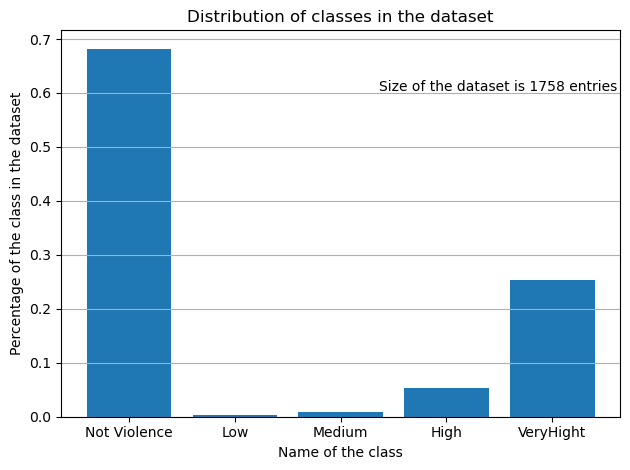

In [6]:
df_final,train_data, test_data, train_target, test_target = DataProcess.division(df_final)
train_target_ordered=train_target.reset_index(drop=True)

In [7]:
DataProcess.export_vect()

In [8]:
print(train_data.shape)

(1230, 6545)


In [9]:
train_target.info()
print(train_target.unique())

<class 'pandas.core.series.Series'>
Index: 1230 entries, 1392 to 1433
Series name: Classe de Violência
Non-Null Count  Dtype 
--------------  ----- 
1230 non-null   object
dtypes: object(1)
memory usage: 19.2+ KB
['Not Violence' 'VeryHight' 'High' 'Low' 'Medium']


## Testando Modelos de Classificação

### Modelo dummy

In [10]:
model=ModelProcessing.dummy_model(train_data,train_target)

['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted']
[0.0005453109741210937, 0.0036803245544433593, 0.6821138211382114, 0.46528190891665017, 0.6821138211382114, 0.5532089385532238]
best recall: 0.6821138211382114
best accuracy: 0.6821138211382114
best f1: 0.5532089385532238
best precision: 0.46528190891665017


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being

Mean APS: 0.5288591446890079
stardard deviation APS: 0.001889087183554805


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


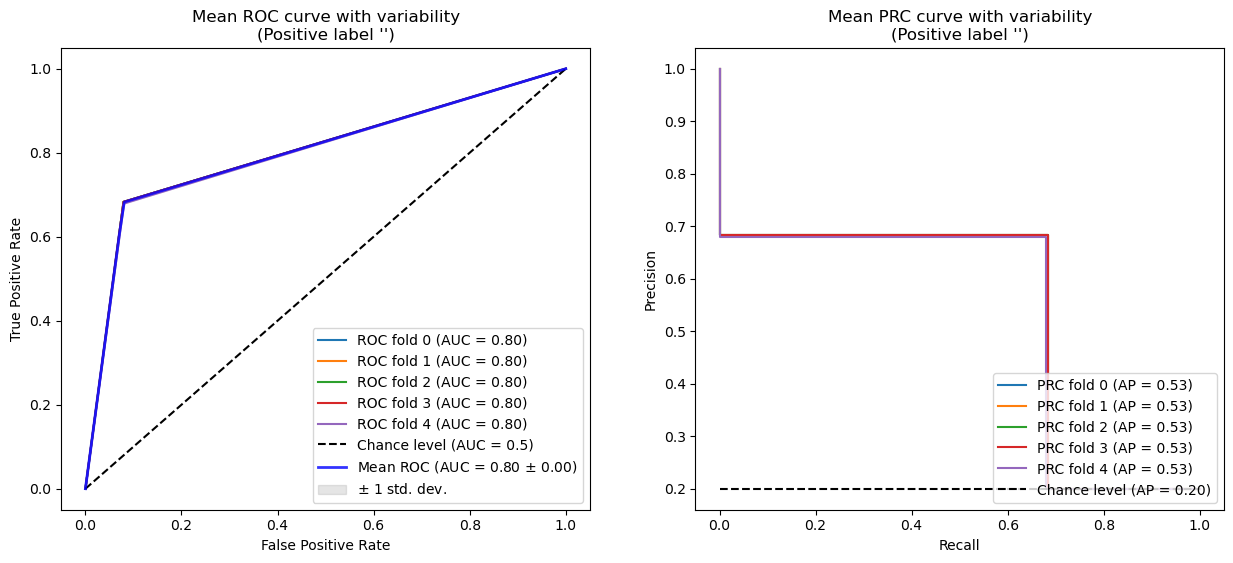

In [11]:
MetricsProcessing().evaluate_alt(model,train_data.toarray(),train_target_ordered)

### AdaBoost sem sampling

In [12]:
best_model=ModelProcessing.adaboost_model(train_data,train_target)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarni

best number of estimators: 4
best recall: 0.7382113821138212
best accuracy: 0.7382113821138212
best f1: 0.6732950909149873
best precision: 0.688366825142011


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Mean APS: 0.6609550332973548
stardard deviation APS: 0.0022873206928626833


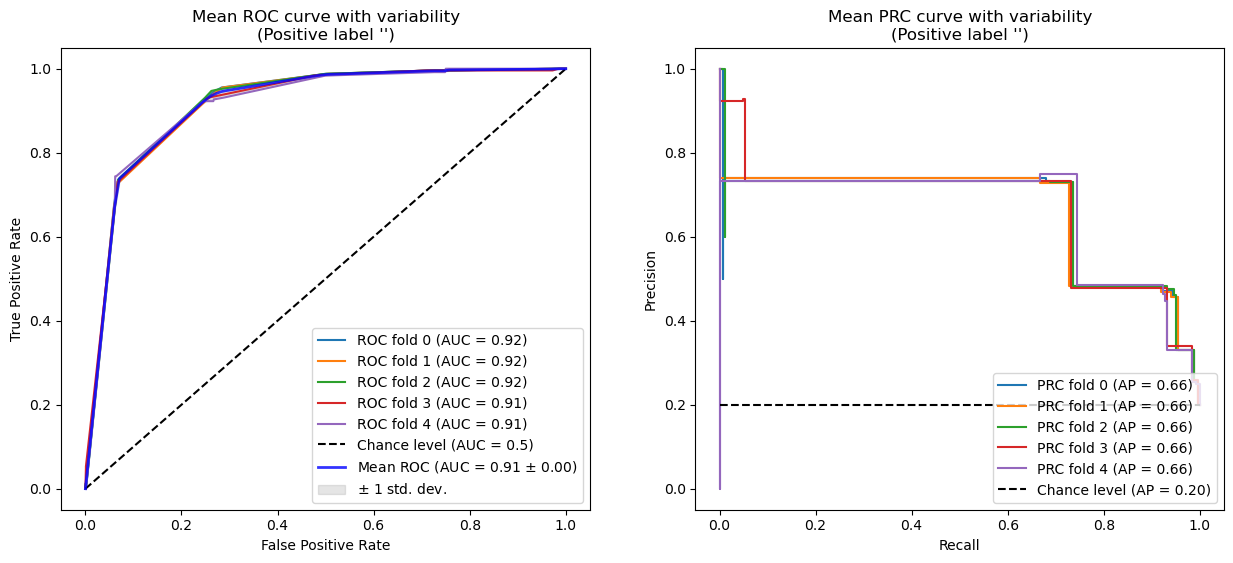

In [14]:
MetricsProcessing().evaluate_alt(best_model,train_data.toarray(),train_target_ordered)

### Floresta Aleatoria sem Sampling

In [15]:
best_model=ModelProcessing.florest_model(train_data,train_target)

  0%|          | 0/49 [00:00<?, ?it/s]/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarni

best depth: 29
best size: 11
best recall: 0.7975609756097561
best accuracy: 0.7975609756097561
best f1: 0.7572619768620473
best precision: 0.7632119734895343


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Mean APS: 0.8747369717648612
stardard deviation APS: 0.012032335455740843


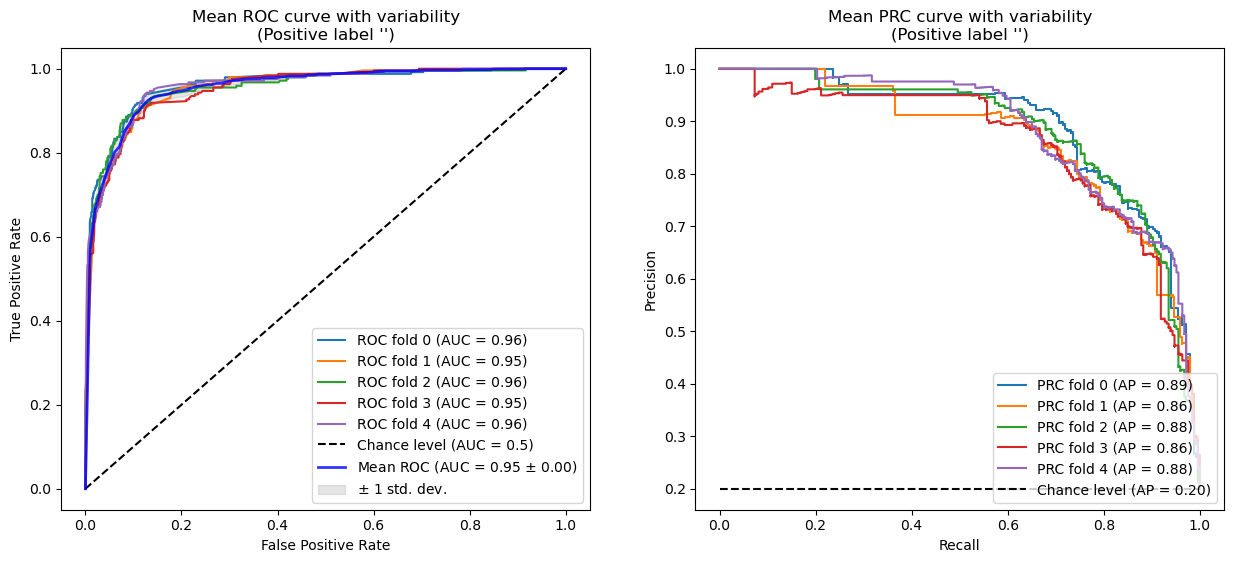

In [16]:
MetricsProcessing().evaluate_alt(best_model,train_data.toarray(),train_target_ordered)

### Arvore de decisão sem Sampling

In [17]:
tree_model=ModelProcessing.tree_model(train_data,train_target)

  0%|          | 0/99 [00:00<?, ?it/s]/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarni

best depth: 35
best recall: 0.8121951219512195
best accuracy: 0.8121951219512195
best f1: 0.799901853113951
best precision: 0.7930048109374395


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Mean APS: 0.6792179422573839
stardard deviation APS: 0.048468734919183194


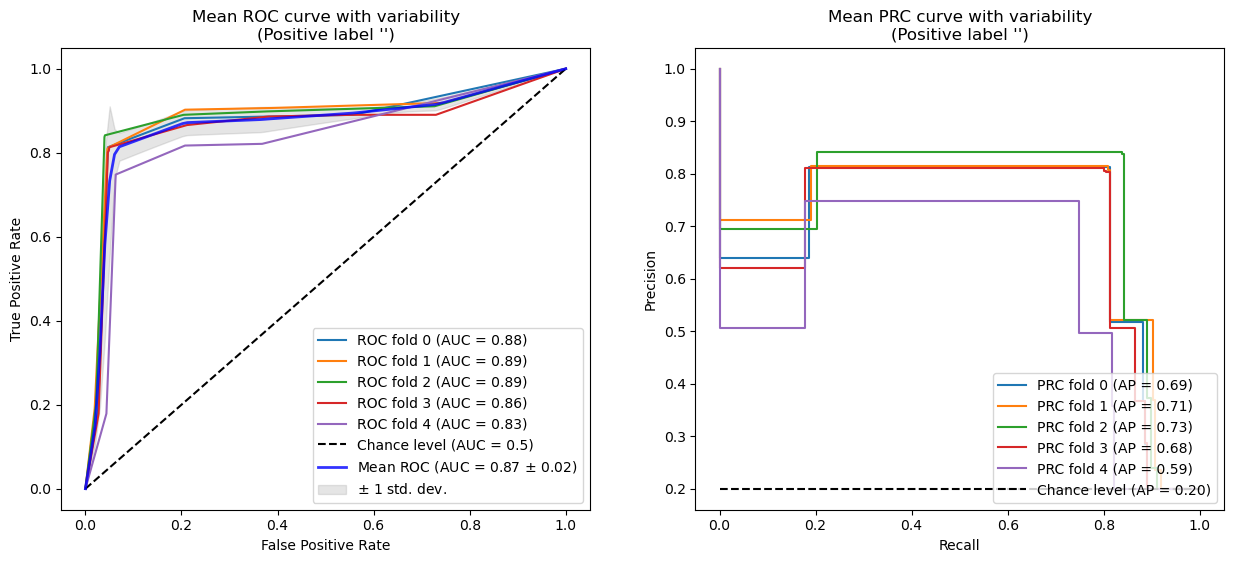

In [18]:
MetricsProcessing().evaluate_alt(tree_model,train_data.toarray(),train_target_ordered)

### Naive-Bayes sem sampling

In [19]:
model=ModelProcessing.naivebayes_model(train_data.toarray(),train_target)

/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


['fit_time', 'score_time', 'test_accuracy', 'test_f1_weighted', 'test_precision_weighted', 'test_recall_weighted']
[0.03330111503601074, 0.01639719009399414, 0.724390243902439, 0.7654190222928292, 0.724390243902439, 0.739238693032941]
best recall: 0.724390243902439
best accuracy: 0.724390243902439
best f1: 0.739238693032941
best precision: 0.7654190222928292


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


Mean APS: 0.5692048383898474
stardard deviation APS: 0.02551570434385846


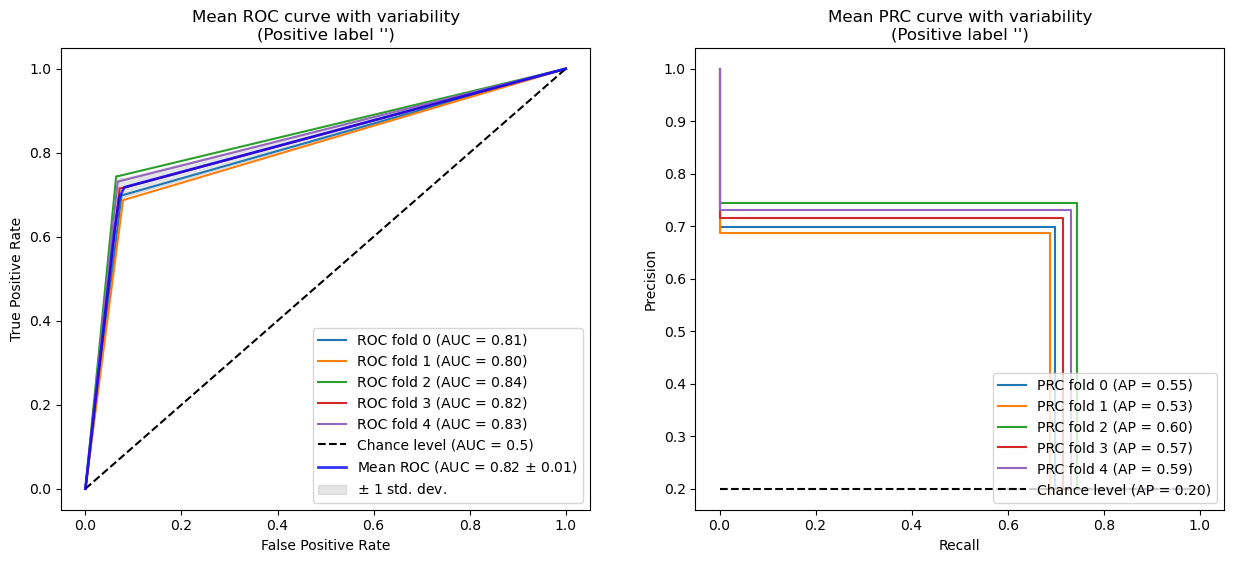

In [20]:
MetricsProcessing().evaluate_alt(model,train_data.toarray(),train_target_ordered)

### BERTimbau sem sampling

In [ ]:
temp=df_final.copy()
bert_class=BertProcessing()
train_dataset,test_dataset=bert_class.loader(df_final=temp)

Generating train split: 1230 examples [00:00, 55606.39 examples/s]
Generating test split: 528 examples [00:00, 120332.13 examples/s]
Map:   0%|          | 0/1230 [00:00<?, ? examples/s]/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Map: 100%|██████████| 528/528 [00:48<00:00, 10.99 examples/s]


In [ ]:
#features_train, target_train, features_test, target_test=DataProcess.bert_division(df_final=df_final)
print(train_dataset)

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1230
})


In [ ]:
model=bert_class.model(train_dataset,test_dataset)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
 34%|███▎      | 155/462 [00:28<04:26,  1.15it/s]

{'eval_loss': 0.48215046525001526, 'eval_accuracy': 0.8541666666666666, 'eval_precision': 0.820204481419334, 'eval_recall': 0.8541666666666666, 'eval_f1': 0.8309511337969567, 'eval_runtime': 1.8662, 'eval_samples_per_second': 282.926, 'eval_steps_per_second': 35.366, 'epoch': 1.0}


 67%|██████▋   | 309/462 [00:49<01:37,  1.56it/s]

{'eval_loss': 0.41533729434013367, 'eval_accuracy': 0.8731060606060606, 'eval_precision': 0.8271545992134228, 'eval_recall': 0.8731060606060606, 'eval_f1': 0.8469098675034866, 'eval_runtime': 1.653, 'eval_samples_per_second': 319.427, 'eval_steps_per_second': 39.928, 'epoch': 2.0}


100%|██████████| 462/462 [01:12<00:00,  6.33it/s]
/Users/mhctds/visage-V1.1/env/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


{'eval_loss': 0.47711309790611267, 'eval_accuracy': 0.8806818181818182, 'eval_precision': 0.8619804463554464, 'eval_recall': 0.8806818181818182, 'eval_f1': 0.8700460994237051, 'eval_runtime': 1.3839, 'eval_samples_per_second': 381.541, 'eval_steps_per_second': 47.693, 'epoch': 3.0}
{'train_runtime': 72.9685, 'train_samples_per_second': 50.57, 'train_steps_per_second': 6.332, 'train_loss': 0.3916884913589015, 'epoch': 3.0}


Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.88  0.79
ROC AUC    0.96  0.92


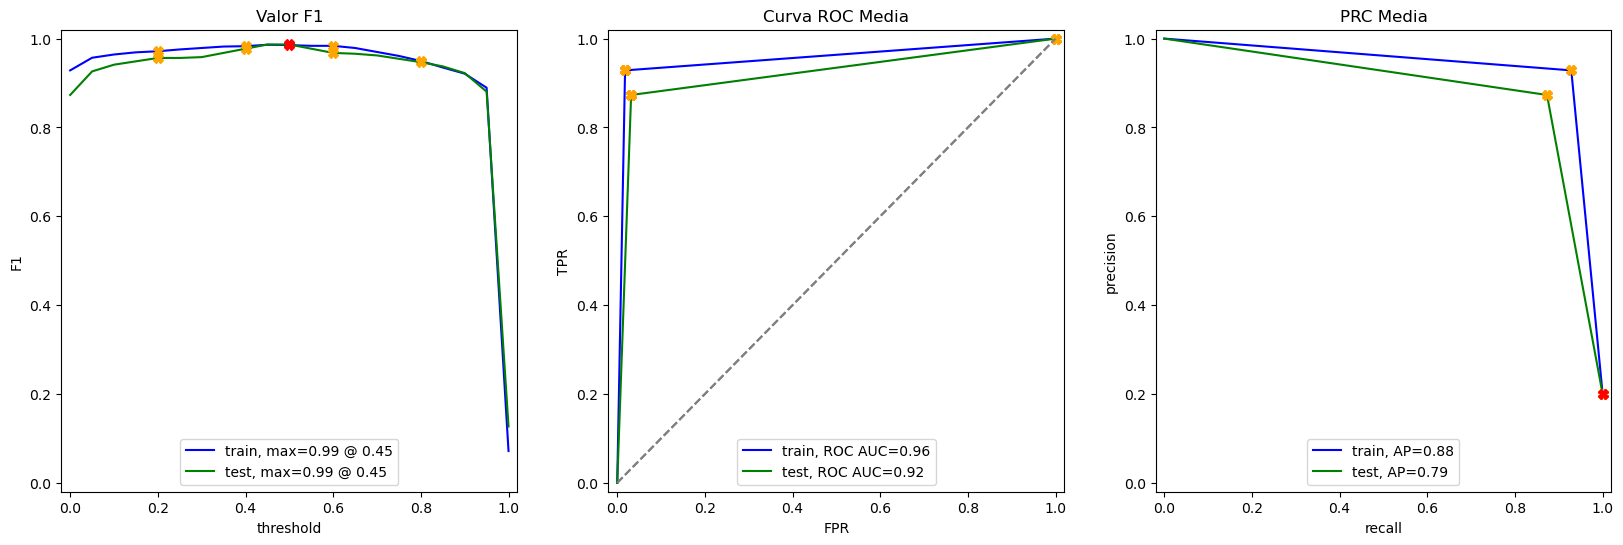

In [ ]:
bert_class.evaluate(model,train_dataset,test_dataset)

In [ ]:
df_sampled,garbage=train_test_split(temp.drop_duplicates().reset_index(), test_size=0.3, random_state=12345,shuffle=True,stratify=df_final['Classe de Violência'])

In [ ]:
prediction=DataProcess.convert_label(bert_class.predict(model,garbage['text'])[:]['label'])

In [ ]:
temp2=test_target.copy()
recall=recall_score(DataProcess.numerical_target(temp2),prediction,average='weighted')
acc=accuracy_score(temp2,prediction)
f1=f1_score(temp2,prediction,average='weighted')
precision=precision_score(temp2,prediction,average='weighted',zero_division=0)
print('best recall:',recall)
print('best accuracy:',acc)
print('best f1:',f1)
print('best precision:',precision)

best recall: 0.8806818181818182
best accuracy: 0.8806818181818182
best f1: 0.8700460994237051
best precision: 0.8619804463554464


## Sampling os dados

In [ ]:
features_sampled,target_sampled=DataProcess.upsampled_division(df_final)

In [ ]:
test_target

941     Not Violence
1053    Not Violence
21      Not Violence
1372       VeryHight
1614    Not Violence
            ...     
1386            High
1563    Not Violence
855        VeryHight
394        VeryHight
892        VeryHight
Name: Classe de Violência, Length: 528, dtype: object

### AdaBoost com sampling

In [ ]:
best_model=ModelProcessing.adaboost_model(features_sampled,target_sampled,test_data,test_target)

  0%|          | 0/99 [00:00<?, ?it/s]

best number of estimators: 5
best recall: 0.017045454545454544
best accuracy: 0.017045454545454544
best f1: 0.016038288482548443
best precision: 0.1757664400080837


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.34  0.33
ROC AUC    0.66  0.64


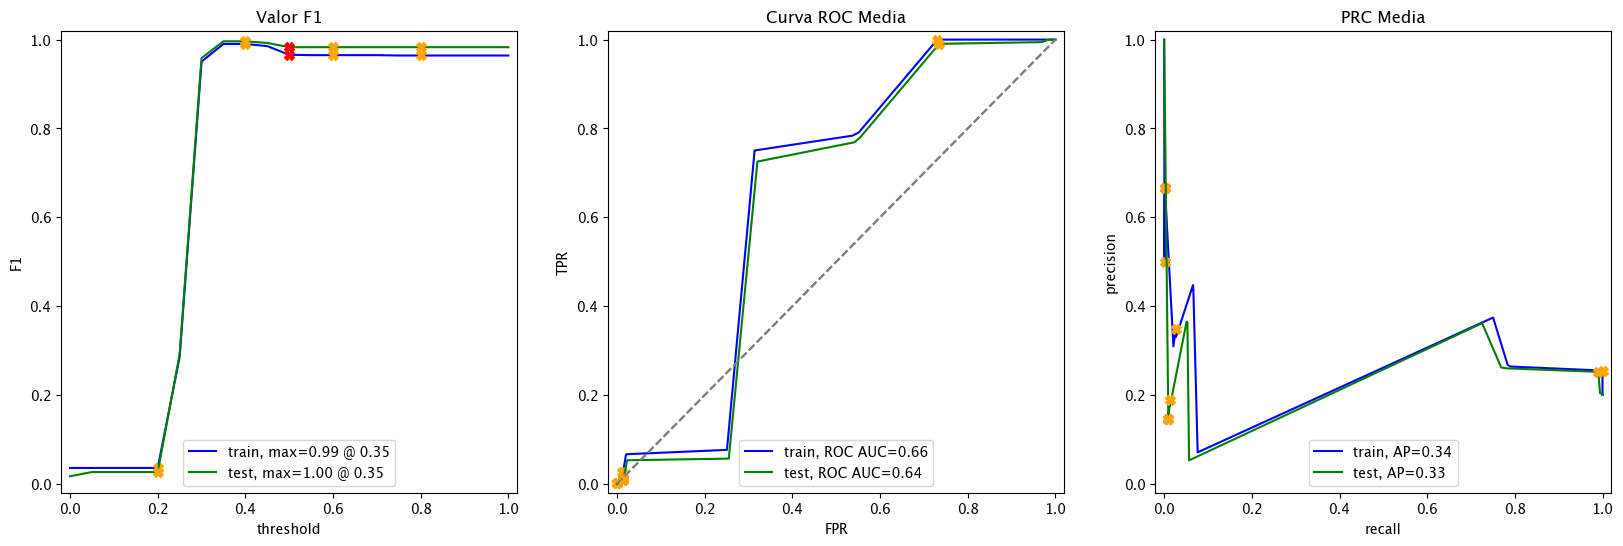

In [ ]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Floresta Aleatoria com Sampling

In [ ]:
best_model=ModelProcessing.florest_model(features_sampled,target_sampled,test_data,test_target)

  0%|          | 0/49 [00:00<?, ?it/s]

best depth: 29
best size: 21
best recall: 0.7632575757575758
best accuracy: 0.7632575757575758
best f1: 0.7237333848128602
best precision: 0.7937946306755943


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.90  0.81
ROC AUC    0.97  0.93


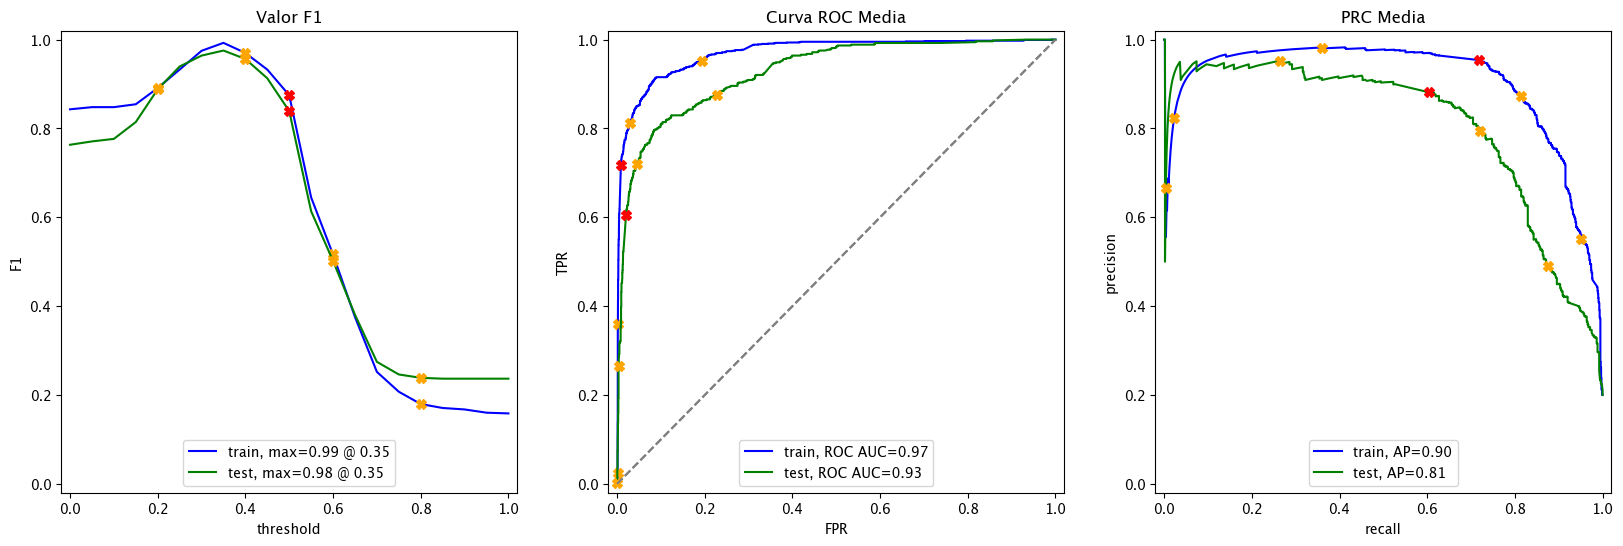

In [ ]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Arvore de decisão com Sampling

In [ ]:
best_model=ModelProcessing.tree_model(features_sampled,target_sampled,test_data,test_target)

tree_model_upsampling=best_model

  0%|          | 0/99 [00:00<?, ?it/s]

best depth: 38
best recall: 0.7954545454545454
best accuracy: 0.7954545454545454
best f1: 0.788440383620773
best precision: 0.8106343557476484


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.97  0.68
ROC AUC    0.99  0.88


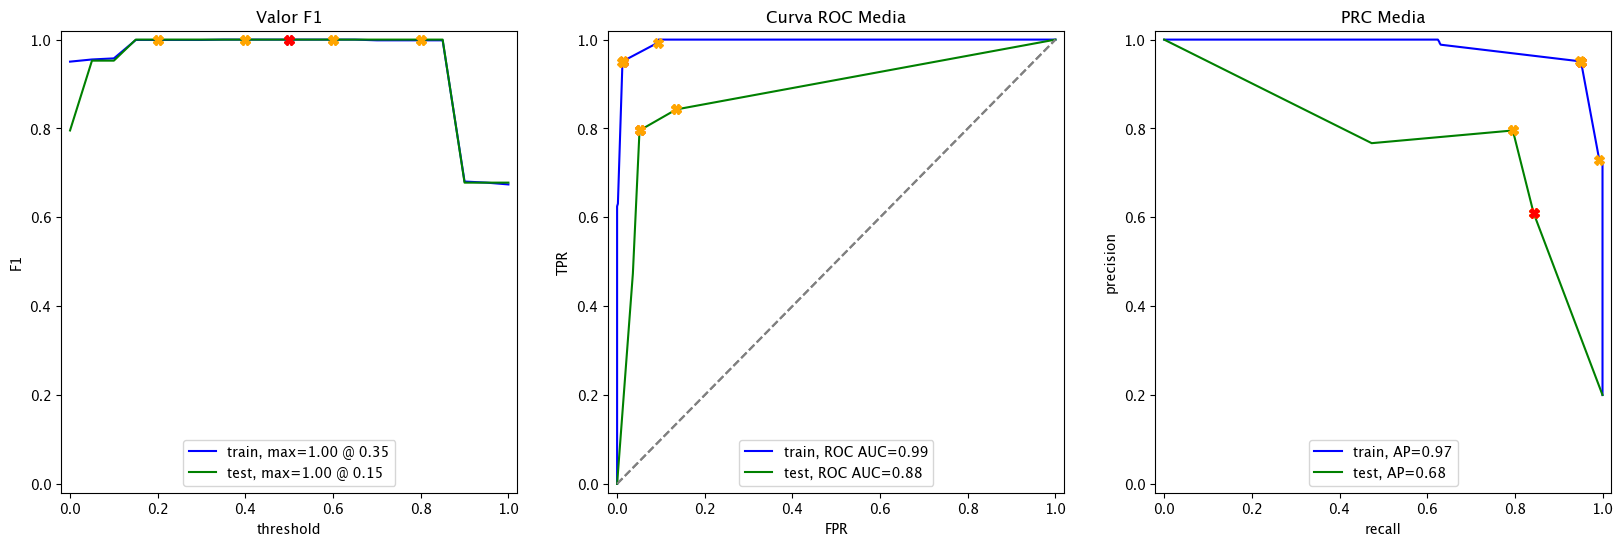

In [ ]:
MetricsProcessing().evaluate_model(best_model,train_data.toarray(),train_target,test_data.toarray(),test_target)

### Naive-Bayes com sampling

In [ ]:
model=ModelProcessing.naivebayes_model(features_sampled,target_sampled,test_data,test_target)

best recall: 0.7329545454545454
best accuracy: 0.7329545454545454
best f1: 0.7511976381461676
best precision: 0.7753840488215488


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.91  0.59
ROC AUC    0.97  0.83


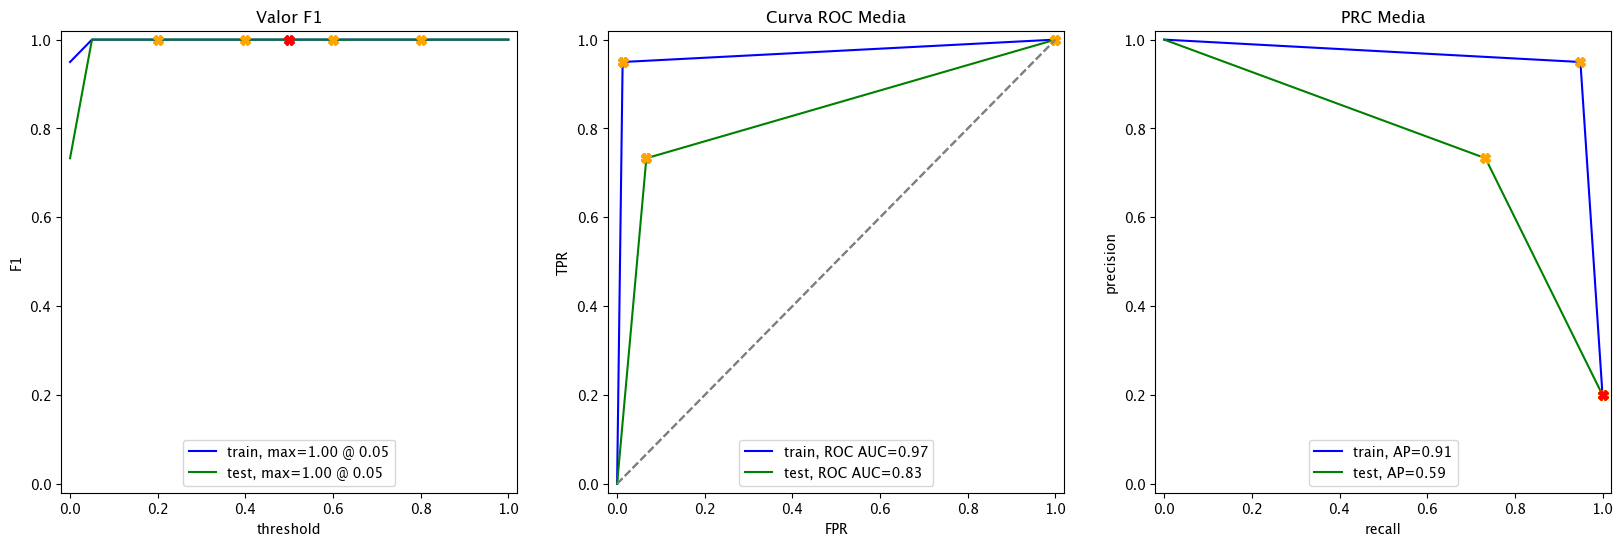

In [ ]:
MetricsProcessing().evaluate_model(model,train_data.toarray(),train_target,test_data.toarray(),test_target)

## Analise da complexidade dos dados sem sampling vs com sampling usando PCA

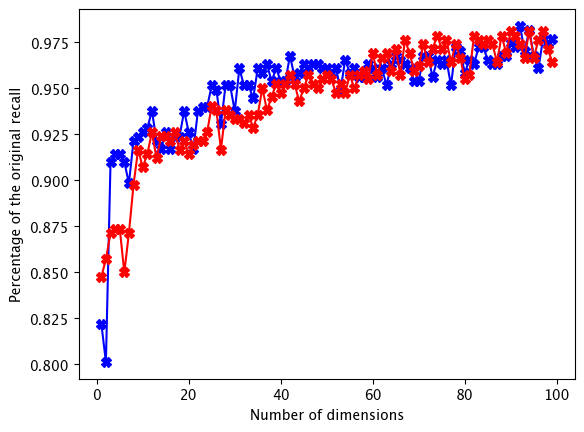

In [ ]:
MetricsProcessing.pca_evaluator(model=tree_model,model2=tree_model_upsampling,test_data=test_data,test_target=test_target,n_components=100)

# Conclusões

Por enquanto o melhor modelo entre eles, sem contar o XGBoost, parece ser a arvore de decisão.

Parece valer a pena testar a vetorização com por NILC quando testarmos regressão.

Normalização da uma pequena melhora em alguns dos modelos, mas talvez seja por coincidencia (a seed ser boa para aquele novo formato de matriz especifica)